<a href="https://colab.research.google.com/github/Harish-topper12/Deep_Learning_Assignment/blob/main/Deep_Learning_Assignment3_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Required Imports and Initial Setup

In [ ]:
# Required imports

# For downloading financial data from Yahoo Finance
import yfinance as yf

# For numerical operations
import numpy as np

# For data manipulation
import pandas as pd

# TensorFlow for building and training neural network models
import tensorflow as tf

# For scaling data
from sklearn.preprocessing import MinMaxScaler

# For building neural network models
from tensorflow.keras.models import Sequential

# Various layers for neural network
from tensorflow.keras.layers import LSTM, SimpleRNN, Dense, Flatten, Dropout

# For plotting graphs
import matplotlib.pyplot as plt

# For seasonal decomposition in time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# For Dickey-Fuller test to check stationarity
from statsmodels.tsa.stattools import adfuller

# For implementing early stopping in model training
from tensorflow.keras.callbacks import EarlyStopping

# Set random seeds for reproducibility

# Setting seed for NumPy operations to ensure reproducible results
np.random.seed(42)

# Setting seed for TensorFlow operations to ensure reproducible results
tf.random.set_seed(42)



### Function Definitions

#### Function to Load Stock Data

In [ ]:
# Function to load stock data
def load_stock_data(stock_symbol, start_date, end_date):
    """
    Downloads stock data for a given symbol over a specified date range.

    Args:
        stock_symbol (str): The ticker symbol of the stock (e.g., 'AAPL' for Apple Inc.).
        start_date (str): The start date for the data in 'YYYY-MM-DD' format.
        end_date (str): The end date for the data in 'YYYY-MM-DD' format.

    Returns:
        pandas.DataFrame: DataFrame containing the stock data.
    """
    data = yf.download(stock_symbol, start=start_date, end=end_date)
    return data

### Function for Initial Data Exploration

In [ ]:
# Function to perform initial data exploration
def initial_data_exploration(stock_data, stock_name):
    print(f"Data Head for {stock_name}:")
    print(stock_data.head())
    print(f"\nData Info for {stock_name}:")
    print(stock_data.info())
    print(f"\nData Description for {stock_name}:")
    print(stock_data.describe())

#### Function to Create Dataset

In [ ]:
def create_dataset(dataset, time_step):
    """
    Creates a dataset for time series forecasting.

    This function generates sequences of a specified length (time_step) from the dataset,
    where each sequence is used to predict the next value in the time series.

    Args:
        dataset (numpy.ndarray): The time series dataset.
        time_step (int): The number of time steps to include in each sequence.

    Returns:
        tuple: Two numpy arrays, X and Y, where X is the sequence of data and Y is the label for each sequence.
    """
    X, Y = [], []
    # Loop over the dataset to create sequences (X) and labels (Y)
    for i in range(len(dataset) - time_step - 1):
        # Append the sequence of data to X
        X.append(dataset[i:(i + time_step), 0])
        # Append the label (next value in the sequence) to Y
        Y.append(dataset[i + time_step, 0])
    # Convert lists to numpy arrays
    return np.array(X), np.array(Y)


#### Function for Exploratory Data Analysis (EDA)

In [ ]:
def perform_eda(data, stock_name):
    """
    Performs Exploratory Data Analysis (EDA) on stock price data.

    Args:
        data (pandas.DataFrame): DataFrame containing the stock price data.
        stock_name (str): Name of the stock (for titling plots).

    This function performs the following analyses:
    1. Plots the closing prices of the stock.
    2. Calculates and plots 50-day and 200-day moving averages.
    3. Performs seasonal decomposition of the stock prices.
    4. Conducts the Dickey-Fuller test to check stationarity.
    """

    # Plotting Stock Price Trends
    plt.figure(figsize=(12, 6))
    plt.plot(data['Close'], label='Closing Price')
    plt.title(f'{stock_name} Stock Closing Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    # Calculating and Plotting Moving Averages
    data['MA50'] = data['Close'].rolling(window=50).mean()
    data['MA200'] = data['Close'].rolling(window=200).mean()
    plt.figure(figsize=(12, 6))
    plt.plot(data['Close'], label='Closing Price')
    plt.plot(data['MA50'], label='50-Day MA')
    plt.plot(data['MA200'], label='200-Day MA')
    plt.title(f'{stock_name} Stock Prices with Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    # Seasonal Decomposition Analysis
    decomposition = seasonal_decompose(data['Close'], model='multiplicative', period=365)
    plt.figure(figsize=(14, 7))
    plt.subplot(411)
    plt.plot(decomposition.observed, label='Observed')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonal')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residual')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

    # Dickey-Fuller Test for Stationarity
    result = adfuller(data['Close'])
    print(f'{stock_name} - ADF Statistic: {result[0]}')
    print(f'{stock_name} - p-value: {result[1]}')

    # ACF plot
    plt.figure(figsize=(12, 4))
    plot_acf(data['Close'], lags=50, alpha=0.05)
    plt.title(f'Autocorrelation Function for {stock_name}')
    plt.show()

    # PACF plot
    plt.figure(figsize=(12, 4))
    plot_pacf(data['Close'], lags=50, alpha=0.05)
    plt.title(f'Partial Autocorrelation Function for {stock_name}')
    plt.show()

#### Function for Data Preprocessing

In [ ]:
def preprocess_data(close_prices, time_step, scaler=None):
    """
    Preprocesses the stock price data for LSTM model training.

    Args:
        close_prices (numpy.ndarray): Array of closing prices of the stock.
        time_step (int): The number of time steps to include in each sequence.
        scaler (MinMaxScaler, optional): Scaler for data normalization.
                                         If None, a new scaler will be created and fitted.

    Returns:
        tuple: Preprocessed training, validation, and testing datasets (X and y),
               and the scaler used for data normalization.
    """

    # Splitting the data into training, validation, and testing sets
    train_size = int(len(close_prices) * 0.7)
    val_size = int(len(close_prices) * 0.15)
    train_data = close_prices[:train_size]
    val_data = close_prices[train_size:train_size + val_size]
    test_data = close_prices[train_size + val_size:]

    # Scaling the data
    if scaler is None:
        # If no scaler is provided, create a new one and fit it to the training data
        scaler = MinMaxScaler(feature_range=(0, 1))
        train_data_scaled = scaler.fit_transform(train_data)
    else:
        # If a scaler is provided, use it to transform the data
        train_data_scaled = scaler.transform(train_data)

    val_data_scaled = scaler.transform(val_data)
    test_data_scaled = scaler.transform(test_data)

    # Creating sequences for model training
    X_train, y_train = create_dataset(train_data_scaled, time_step)
    X_val, y_val = create_dataset(val_data_scaled, time_step)
    X_test, y_test = create_dataset(test_data_scaled, time_step)

    # Reshaping input for LSTM
    # LSTM expects input to be in the form of [samples, time steps, features]
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    return X_train, y_train, X_val, y_val, X_test, y_test, scaler


#### Functions to Build Models

In [ ]:
def build_baseline_model(input_shape, neurons, dropout_rate, recurrent_dropout=None):
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(neurons, activation='relu'),
        Dropout(dropout_rate),
        Dense(1)
    ])
    return model

In [ ]:
def build_rnn_model(input_shape, neurons, dropout_rate, recurrent_dropout):
    model = Sequential([
        SimpleRNN(neurons, return_sequences=True, input_shape=input_shape, dropout=dropout_rate, recurrent_dropout=recurrent_dropout),
        SimpleRNN(neurons, dropout=dropout_rate, recurrent_dropout=recurrent_dropout+0.1),
        Dense(1)
    ])
    return model

In [ ]:
def build_lstm_model(input_shape, neurons, dropout_rate, recurrent_dropout):
    model = Sequential([
        LSTM(neurons, return_sequences=True, input_shape=input_shape, dropout=dropout_rate, recurrent_dropout=recurrent_dropout),
        LSTM(neurons, dropout=dropout_rate, recurrent_dropout=recurrent_dropout+0.1),
        Dense(1)
    ])
    return model

#### Function to Train and Evaluate Models

In [ ]:
# Training and evaluation
def train_and_evaluate(model_builder, neurons, dropout_rate, recurrent_dropout, X_train, y_train, X_val, y_val):
    model = model_builder((X_train.shape[1], 1), neurons, dropout_rate, recurrent_dropout)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=64, callbacks = [early_stopping])
    return model, history

#### Function to Plot Training and Validation Loss Curves

In [ ]:
# Plot training and validation loss curves
def plot_loss_curves(history, model_name, title):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{title} for {model_name}" )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

#### Function for Full Prediction Plotting

In [ ]:
def plot_full_prediction(best_timestamps, stock, model_name, future_steps=30):
    # Extract best model details
    time_step, model_instance, _, X_train, y_train, X_val, y_val, X_test, y_test, scaler = best_timestamps[(stock, model_name)]

    # Predictions for each dataset
    train_predictions = model_instance.predict(X_train)
    val_predictions = model_instance.predict(X_val)
    test_predictions = model_instance.predict(X_test)

    # Inverse transform the predictions and actuals
    train_predictions_inv = scaler.inverse_transform(train_predictions)
    val_predictions_inv = scaler.inverse_transform(val_predictions)
    test_predictions_inv = scaler.inverse_transform(test_predictions)
    y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
    y_val_inv = scaler.inverse_transform(y_val.reshape(-1, 1))
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Future predictions
    last_sequence = X_test[-1, :, :]
    future_predictions = []
    for _ in range(future_steps):
        last_sequence_pred = model_instance.predict(last_sequence.reshape(1, time_step, 1))
        future_predictions.append(last_sequence_pred[0, 0])
        last_sequence = np.roll(last_sequence, -1, axis=0)
        last_sequence[-1] = last_sequence_pred

    future_predictions_scaled = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

    # Plotting
    plt.figure(figsize=(14, 7))

    # Training predictions
    plt.plot(range(len(y_train_inv)), y_train_inv.flatten(), label='Train Actual')
    plt.plot(range(len(train_predictions_inv)), train_predictions_inv.flatten(), label='Train Predictions')

    # Validation predictions
    offset = len(y_train_inv)
    plt.plot(range(offset, offset + len(y_val_inv)), y_val_inv.flatten(), label='Validation Actual')
    plt.plot(range(offset, offset + len(val_predictions_inv)), val_predictions_inv.flatten(), label='Validation Predictions')

    # Test predictions
    offset += len(y_val_inv)
    plt.plot(range(offset, offset + len(y_test_inv)), y_test_inv.flatten(), label='Test Actual')
    plt.plot(range(offset, offset + len(test_predictions_inv)), test_predictions_inv.flatten(), label='Test Predictions')

    # Future predictions
    offset += len(y_test_inv)
    total_length = offset + len(future_predictions_scaled)
    plt.plot(range(offset, total_length), future_predictions_scaled.flatten(), label='Future Predictions', linestyle='--')

    plt.title(f"{stock} - {model_name} Model Predictions and Future Forecast")
    plt.xlabel('Time Steps')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()


#### Function to Evaluate Models with Best Timestamp

In [ ]:
def evaluate_models_with_best_timestamp(stocks, start_date, end_date, timestamps):
    # Initialize dictionaries to store performance records and best timestamps
    performance_records = {}
    best_performance = {}  # Dictionary to store the best performance (MSE and MAE) for each model and stock

    # Iterate over each stock
    for stock in stocks:
        print(f"\nEvaluating models for {stock}")

        # Download stock data for the given date range and reshape it
        data = yf.download(stock, start=start_date, end=end_date)['Close'].values.reshape(-1, 1)

        # Retrieve model configuration settings (neurons, dropout rates) for the current stock
        neurons = configurations[stock]['neurons']
        dropout_rate = configurations[stock]['dropout_rate']
        recurrent_dropout = configurations[stock]['recurrent_dropout']

        # Initialize a dictionary to track the best performance for each model
        best_performance_per_model = {
            "Baseline": {"mse": float('inf'), "mae": float('inf')},
            "RNN": {"mse": float('inf'), "mae": float('inf')},
            "LSTM": {"mse": float('inf'), "mae": float('inf')}
        }

        # Iterate over each time step
        for time_step in timestamps:
            print(f"\nProcessing time step: {time_step}")

            # Preprocess data for the current time step
            processed_data = preprocess_data(data, time_step)
            if processed_data is None:
                print(f"Preprocessing failed for {stock} at time_step {time_step}")
                continue

            # Unpack preprocessed data
            X_train, y_train, X_val, y_val, X_test, y_test, scaler = processed_data

            # Iterate over each model
            for model_name, model_builder in [("Baseline", build_baseline_model),
                                              ("RNN", build_rnn_model),
                                              ("LSTM", build_lstm_model)]:
                print(f"\nTraining {model_name} model with {neurons} neurons and {dropout_rate} dropout rate...")

                # Train and evaluate the model
                model, history = train_and_evaluate(model_builder, neurons, dropout_rate, recurrent_dropout, X_train, y_train, X_val, y_val)

                # Retrieve MSE and MAE from the model's history
                mse = history.history['val_mse'][-1]
                mae = history.history['val_mae'][-1]

                # Record performance metrics for the current model and time step
                performance_records.setdefault((stock, time_step), {})[model_name] = {'mse': mse, 'mae': mae}

                # Update best performance for the model if current MSE and MAE are lower
                if mse < best_performance_per_model[model_name]["mse"] and mae < best_performance_per_model[model_name]["mae"]:
                    best_performance_per_model[model_name] = {"mse": mse, "mae": mae}
                    best_performance[(stock, model_name)] = (time_step, model, history, X_train, y_train, X_val, y_val, X_test, y_test, scaler)

                print(f"Completed: {model_name} - MSE: {mse}, MAE: {mae}")

        # Print the best performance for each model for the current stock
        print(f"\nBest Performance for {stock}:")
        for model in ["Baseline", "RNN", "LSTM"]:
            if (stock, model) in best_performance:
                best_time_step, _, _, _, _, _, _, _, _, _ = best_performance[(stock, model)]
                best_mse = best_performance_per_model[model]["mse"]
                best_mae = best_performance_per_model[model]["mae"]
                print(f"{model}: Time Step {best_time_step} - MSE: {best_mse}, MAE: {best_mae}")

    # Return the performance records and best performance
    return performance_records, best_performance


#### Function for Tabular Comparison of Models

In [ ]:
# Function to generate a tabular comparison of model performance
def tabular_comparison(best_timestamps):
    # Initialize a list to store data for the table
    table_data = []

    # Iterate over each model's best timestamp data stored in best_timestamps
    for (stock, model), details in best_timestamps.items():
        # Extract details from the best_timestamps dictionary
        time_step, model_instance, history, X_train, y_train, X_val, y_val, X_test, y_test, _ = details

        # Evaluate the model on the training dataset and get training MSE
        train_mse = model_instance.evaluate(X_train, y_train, verbose=0)[1]

        # Retrieve the MSE on the validation dataset from the model's training history
        val_mse = history.history['val_mse'][-1]

        # Evaluate the model on the test dataset and get testing MSE
        test_mse = model_instance.evaluate(X_test, y_test, verbose=0)[1]

        # Append the performance metrics along with stock, model, and timestamp info to the list
        table_data.append([stock, model, time_step, train_mse, val_mse, test_mse])

    # Create a DataFrame from the collected data for easy visualization and comparison
    comparison_df = pd.DataFrame(table_data, columns=["Stock", "Model", "Timestamp", "Train MSE", "Validation MSE", "Test MSE"])

    # Return the DataFrame
    return comparison_df

In [ ]:
# Define the neuron and dropout configurations for each stock
configurations = {
    'AAPL': {'neurons': 64, 'dropout_rate': 0, 'recurrent_dropout': 0},
    'MSFT': {'neurons': 64, 'dropout_rate': 0, 'recurrent_dropout': 0}
}

In [ ]:
def plot_predictions(model_builder, neurons, dropout_rate, recurrent_dropout, X_train, y_train, X_val, y_val, X_test, y_test, scaler, model_name, title):
    # Combine training and validation sets
    X_combined = np.concatenate((X_train, X_val), axis=0)
    y_combined = np.concatenate((y_train, y_val), axis=0)

    # Train the model with the combined dataset
    model, history = train_and_evaluate(model_builder, neurons, dropout_rate, recurrent_dropout, X_combined, y_combined, X_test, y_test)

    # Make predictions
    predictions = scaler.inverse_transform(model.predict(X_test))
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_inv, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.title(f"{title} for {model_name}")
    plt.xlabel('Time')
    plt.ylabel('Normalized Stock Price')
    plt.legend()
    plt.show()


In [ ]:
def plot_performance(performance_records):
    # Iterate over each unique stock and model combination
    for (stock, _), data in performance_records.items():
        # Initialize dictionaries to store MSE and MAE for each model
        mse_data = {'Baseline': [], 'RNN': [], 'LSTM': []}
        mae_data = {'Baseline': [], 'RNN': [], 'LSTM': []}
        time_steps = []

        # Collect the performance data
        for time_step, model_data in data.items():
            time_steps.append(time_step)
            for model in ['Baseline', 'RNN', 'LSTM']:
                mse_data[model].append(model_data[model]['mse'])
                mae_data[model].append(model_data[model]['mae'])

        # Plot MSE
        plt.figure(figsize=(10, 4))
        for model in ['Baseline', 'RNN', 'LSTM']:
            plt.plot(time_steps, mse_data[model], label=f"{model} MSE")
        plt.title(f"MSE over different timestamps for {stock}")
        plt.xlabel('Timestamp')
        plt.ylabel('MSE')
        plt.legend()
        plt.show()

        # Plot MAE
        plt.figure(figsize=(10, 4))
        for model in ['Baseline', 'RNN', 'LSTM']:
            plt.plot(time_steps, mae_data[model], label=f"{model} MAE")
        plt.title(f"MAE over different timestamps for {stock}")
        plt.xlabel('Timestamp')
        plt.ylabel('MAE')
        plt.legend()
        plt.show()

### Load Data and Perform EDA

In [ ]:
stocks = ['AAPL', 'MSFT']
for stock in stocks:
    data = load_stock_data(stock, '2009-08-09', '2020-01-01')
    initial_data_exploration(data, stock)

[*********************100%%**********************]  1 of 1 completed
Data Head for AAPL:
                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2009-08-10  5.916429  5.950000  5.845000  5.882857   4.986780  300294400
2009-08-11  5.846071  5.870714  5.781429  5.815357   4.929560  355342400
2009-08-12  5.805357  5.953929  5.802143  5.903929   5.004641  445071200
2009-08-13  5.951786  6.023929  5.946429  6.015000   5.098793  439980800
2009-08-14  5.997857  6.008214  5.911786  5.956429   5.049144  305816000

Data Info for AAPL:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2617 entries, 2009-08-10 to 2019-12-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2617 non-null   float64
 1   High       2617 non-null   float64
 2   Low        2617 non-null   float64
 3   Close      2617 non-null   float64
 4   Adj Close 

**Apple Inc. (AAPL) Analysis:**

    Data Overview:
        The dataset spans from August 10, 2009, to December 31, 2019, encompassing 2617 trading days.
        It includes stock metrics such as Open, High, Low, Close, Adjusted Close (Adj Close), and trading Volume.

    Statistical Summary:
        The average (mean) closing price of AAPL stock is approximately $26.78, with a standard deviation of about $14.34, indicating variability in the stock price over this period.
        The stock experienced a significant range in prices (from a low of about $5.70 to a high of around $73.41) during the observed timeframe.

**Microsoft Corp. (MSFT) Analysis:**

    Data Overview:
        Similar to AAPL, the MSFT dataset covers the same dates and includes the same types of stock metrics.

    Statistical Summary:
        The average closing price for MSFT is about $55.20, with a standard deviation of $33.68, suggesting notable fluctuations in price.
        MSFT's stock prices ranged from a low of around $23.01 to a high of $158.96, showing significant growth and variation over the analyzed period.

**General Observations:**

    1. Both datasets are complete with no missing values, making them suitable for further analysis such as trend identification, performance comparison, or predictive modeling.

    2. The difference in price ranges and standard deviations between AAPL and MSFT reflects their unique stock performance and market behaviors during the analyzed period.

    3. The Adj Close price is adjusted for factors like stock splits and dividends and is key for analyses that require accounting for the true value of the stock over time.

    4. High standard deviations in both stocks indicate notable volatility, which is typical in stock market data and suggests the potential for both risk and reward in trading these stocks.

    5. This analysis sets the stage for deeper investigations, such as comparative performance analysis, volatility studies, or predictive modeling for future price movements.

[*********************100%%**********************]  1 of 1 completed


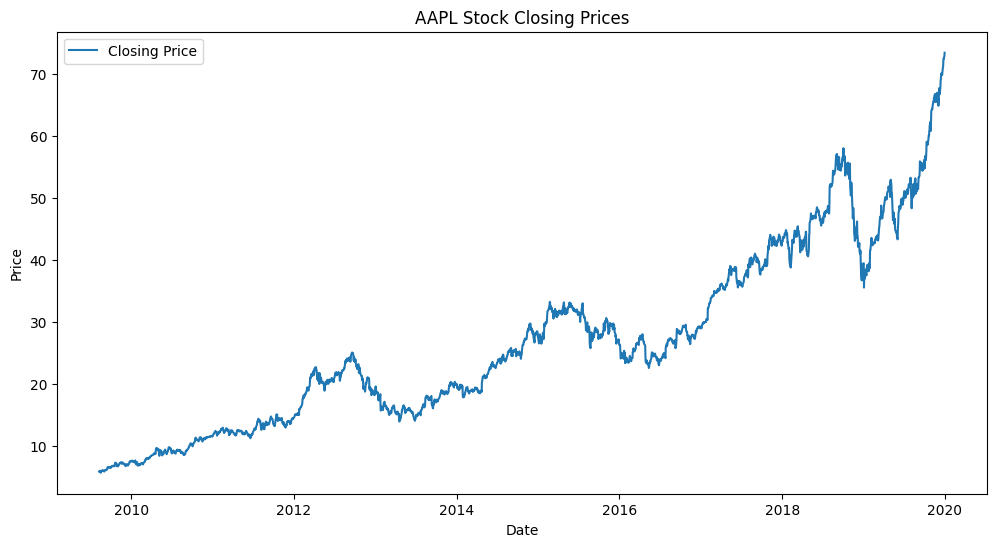

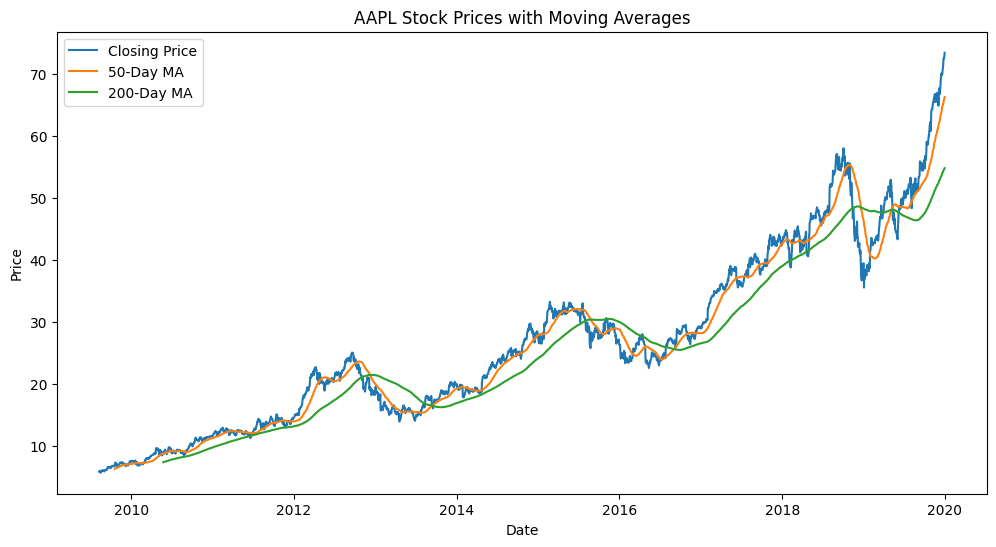

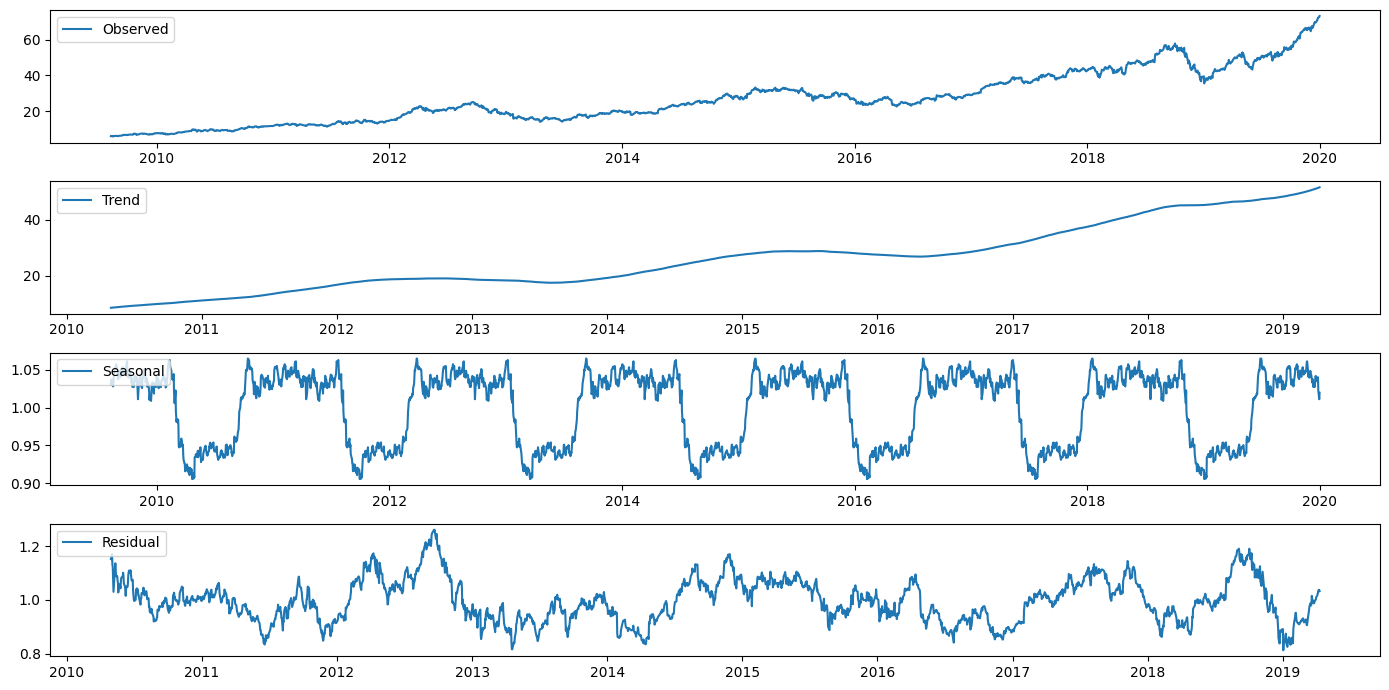

AAPL - ADF Statistic: 1.0545084491575303
AAPL - p-value: 0.9948090442653157


<Figure size 1200x400 with 0 Axes>

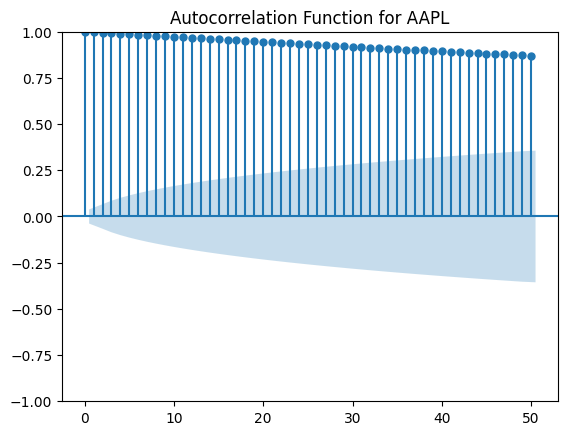

<Figure size 1200x400 with 0 Axes>

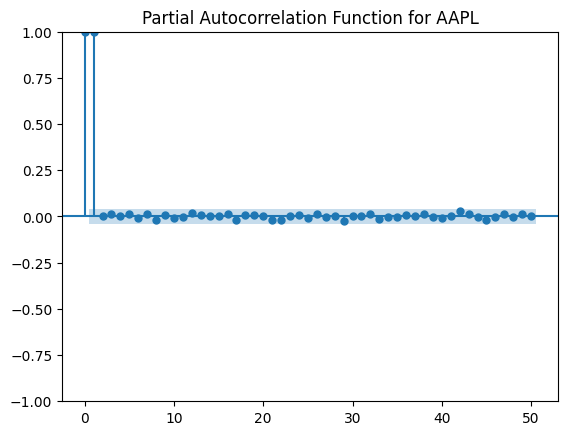

[*********************100%%**********************]  1 of 1 completed


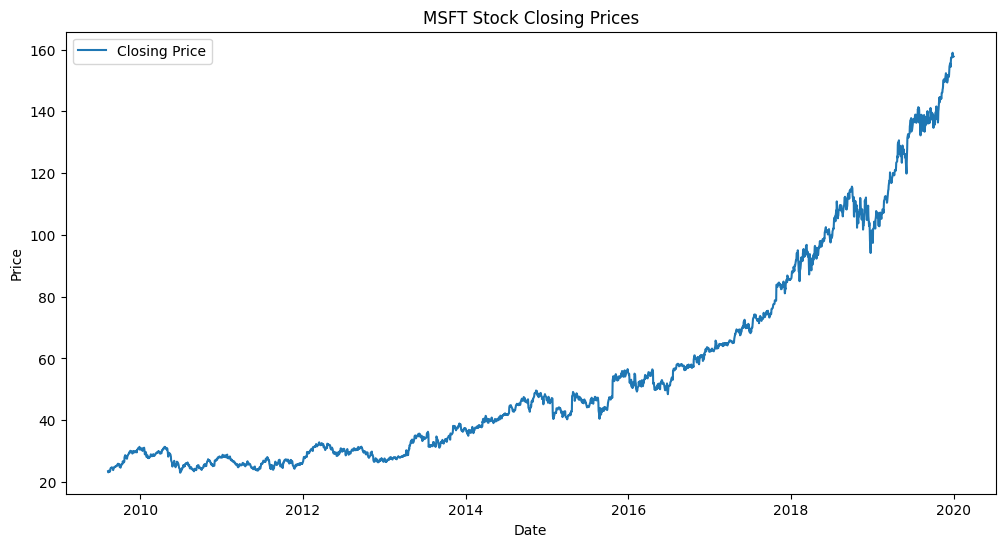

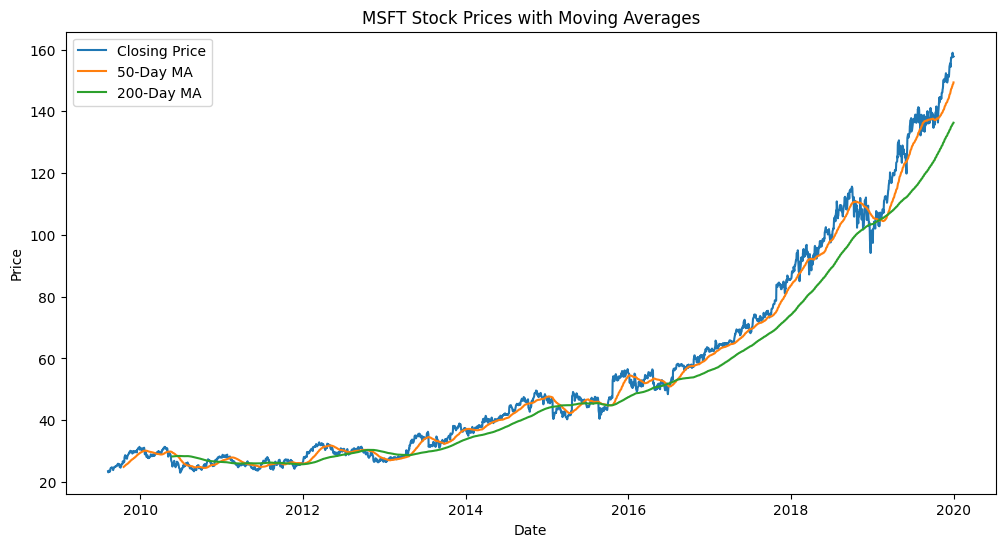

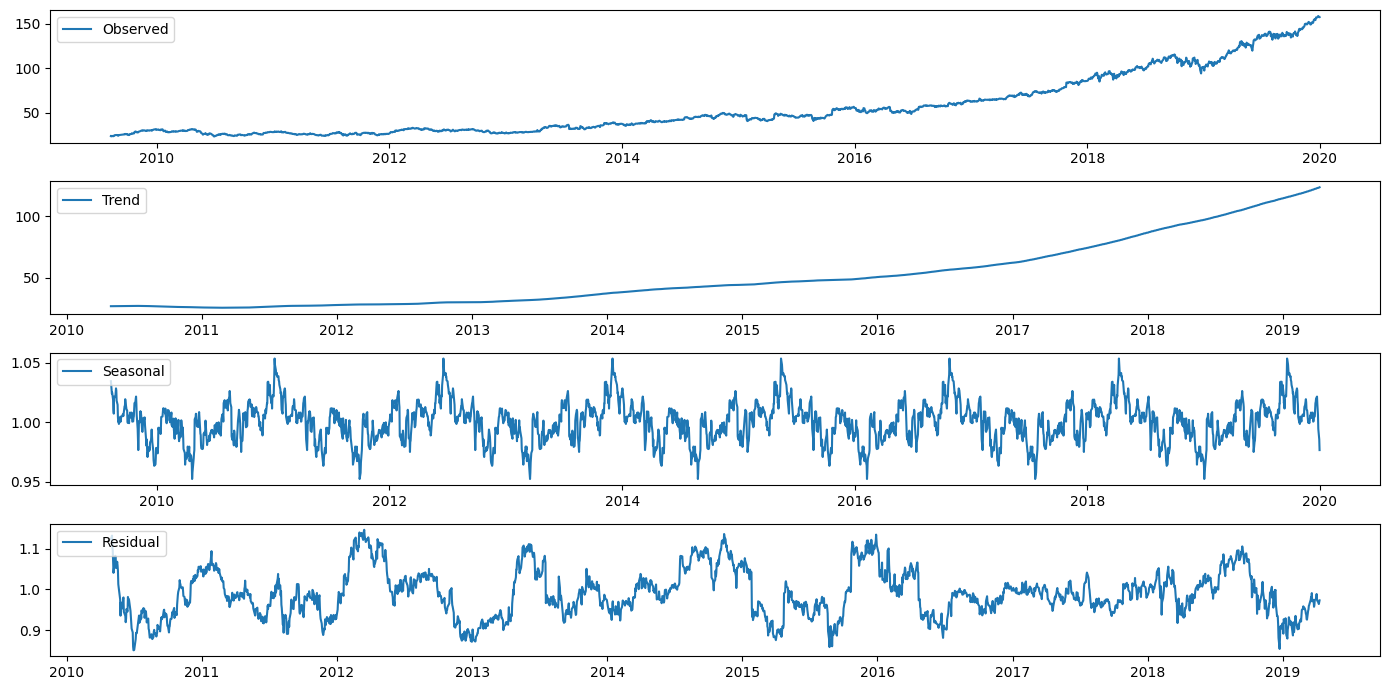

MSFT - ADF Statistic: 4.032951676963924
MSFT - p-value: 1.0


<Figure size 1200x400 with 0 Axes>

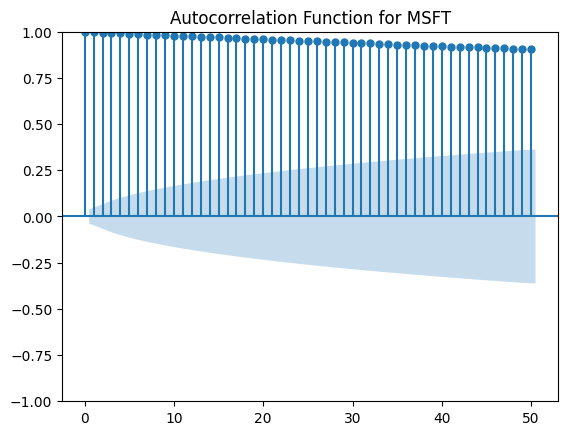

<Figure size 1200x400 with 0 Axes>

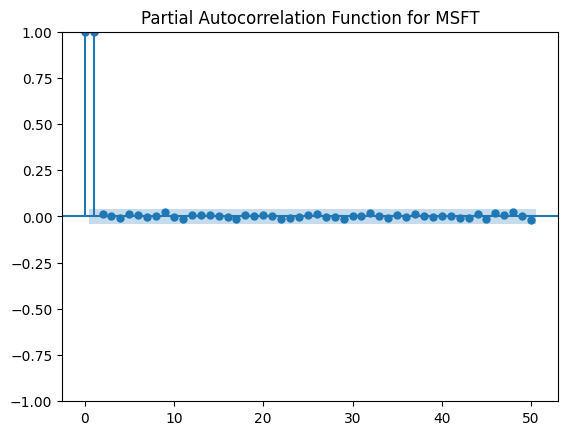

In [ ]:
for stock in stocks:
    data = load_stock_data(stock, '2009-08-09', '2020-01-01')
    perform_eda(data, stock)

#### Apple Inc. (AAPL) stock data

**Growth Trajectory:**

  AAPL's stock price has shown a significant upward trend over the decade. The closing price graph indicates robust growth, with the stock price rising from single digits to over $70 by the end of 2019. This suggests that investors who held the stock over this period likely saw substantial returns on their investment.

**Volatility and Recovery:**

  The closing price graph also displays periods of volatility, with several peaks and troughs. These fluctuations could be the result of various factors, including economic conditions, changes in market sentiment, product launch successes or failures, and broader tech industry trends. Despite this volatility, the overall direction has been positive, with the company showing strong recovery from down periods.

**Seasonal Patterns:**

  The seasonal decomposition highlights consistent patterns within each year, which could be tied to Apple's annual events, such as product launches or holiday sales cycles. These seasonal trends offer potential opportunities for traders to capitalize on predictable movements in stock price.

**Stationarity and Forecasting Challenges:**

  The Augmented Dickey-Fuller (ADF) test indicates that the AAPL stock price series is non-stationary, with a p-value much higher than the conventional threshold for statistical significance. This non-stationarity implies that the stock prices have a time-dependent structure, which can make forecasting more challenging since traditional time series models rely on the assumption of stationarity.


## Microsoft Corporation (MSFT) stock data

**Growth Trajectory:**

MSFT's stock price has exhibited a remarkable rising trend throughout the decade. The graph depicting the closing prices shows a steady ascent from around \$20 to upwards of \$150 by the end of the period under consideration. This robust growth trajectory indicates that MSFT has been a lucrative investment for shareholders, with the stock price multiplying several times over the observed timeframe.

**Moving Averages as Indicators:**

The inclusion of 50-day and 200-day moving averages in the analysis presents a clear picture of intermediate and long-term trends. The stock's price consistently remaining above these moving averages is a bullish signal, often interpreted by investors as a confirmation of the stock's positive momentum.

**Seasonal and Residual Analysis:**

The seasonal decomposition of MSFT's stock prices suggests a lack of pronounced seasonality, with the trend component being the predominant factor in the stock's movement. The residual plot, showing the noise or random fluctuations, indicates that while the stock follows a strong upward trend, there are still many irregular movements not explained by seasonality or trend, which could be attributed to external factors, market dynamics, or specific company-related news.

**Stationarity and Predictive Modeling:**

The Augmented Dickey-Fuller (ADF) test results, with an ADF statistic of 4.033 and a p-value of 1.0, strongly suggest that the stock price series is non-stationary. This has significant implications for predictive modeling as non-stationary data can lead to unreliable forecasts. Such data typically require differencing, detrending, or transformation to achieve stationarity before models like ARIMA can be effectively utilized.

### Model Evaluation and Selection

In [ ]:
timestamps = [30, 60]
performance_records, best_timestamps = evaluate_models_with_best_timestamp(stocks, '2009-08-09', '2020-01-01', timestamps)


Evaluating models for AAPL
[*********************100%%**********************]  1 of 1 completed

Processing time step: 30

Training Baseline model with 64 neurons and 0 dropout rate...
Epoch 1/50
29/29 [==============================] - 6s 46ms/step - loss: 0.2674 - mae: 0.3580 - mse: 0.2674 - val_loss: 0.1047 - val_mae: 0.3134 - val_mse: 0.1047
Epoch 2/50
29/29 [==============================] - 0s 17ms/step - loss: 0.0096 - mae: 0.0758 - mse: 0.0096 - val_loss: 0.0228 - val_mae: 0.1349 - val_mse: 0.0228
Epoch 3/50
29/29 [==============================] - 0s 14ms/step - loss: 0.0028 - mae: 0.0420 - mse: 0.0028 - val_loss: 0.0087 - val_mae: 0.0772 - val_mse: 0.0087
Epoch 4/50
29/29 [==============================] - 1s 20ms/step - loss: 0.0024 - mae: 0.0385 - mse: 0.0024 - val_loss: 0.0088 - val_mae: 0.0784 - val_mse: 0.0088
Epoch 5/50
29/29 [==============================] - 0s 14ms/step - loss: 0.0022 - mae: 0.0356 - mse: 0.0022 - val_loss: 0.0094 - val_mae: 0.0817 - val_mse: 0.0094

Completed: RNN - MSE: 0.0011438237270340323, MAE: 0.02573302760720253

Training LSTM model with 64 neurons and 0 dropout rate...
Epoch 1/50
29/29 [==============================] - 9s 138ms/step - loss: 0.0342 - mae: 0.1232 - mse: 0.0342 - val_loss: 0.0110 - val_mae: 0.0874 - val_mse: 0.0110
Epoch 2/50
29/29 [==============================] - 5s 163ms/step - loss: 0.0017 - mae: 0.0322 - mse: 0.0017 - val_loss: 0.0071 - val_mae: 0.0705 - val_mse: 0.0071
Epoch 3/50
29/29 [==============================] - 3s 117ms/step - loss: 8.8906e-04 - mae: 0.0222 - mse: 8.8906e-04 - val_loss: 0.0085 - val_mae: 0.0794 - val_mse: 0.0085
Epoch 4/50
29/29 [==============================] - 3s 113ms/step - loss: 8.7980e-04 - mae: 0.0220 - mse: 8.7980e-04 - val_loss: 0.0063 - val_mae: 0.0653 - val_mse: 0.0063
Epoch 5/50
29/29 [==============================] - 4s 132ms/step - loss: 8.5337e-04 - mae: 0.0218 - mse: 8.5337e-04 - val_loss: 0.0047 - val_mae: 0.0545 - val_mse: 0.0047
Epoch 6/50
29/29 [=========

Completed: RNN - MSE: 0.0011340401833876967, MAE: 0.025163915008306503

Training LSTM model with 64 neurons and 0 dropout rate...
Epoch 1/50
28/28 [==============================] - 13s 313ms/step - loss: 0.0718 - mae: 0.1768 - mse: 0.0718 - val_loss: 0.0186 - val_mae: 0.1244 - val_mse: 0.0186
Epoch 2/50
28/28 [==============================] - 6s 206ms/step - loss: 0.0030 - mae: 0.0455 - mse: 0.0030 - val_loss: 0.0049 - val_mae: 0.0566 - val_mse: 0.0049
Epoch 3/50
28/28 [==============================] - 8s 290ms/step - loss: 9.4252e-04 - mae: 0.0232 - mse: 9.4252e-04 - val_loss: 0.0032 - val_mae: 0.0443 - val_mse: 0.0032
Epoch 4/50
28/28 [==============================] - 6s 211ms/step - loss: 8.3761e-04 - mae: 0.0218 - mse: 8.3761e-04 - val_loss: 0.0052 - val_mae: 0.0595 - val_mse: 0.0052
Epoch 5/50
28/28 [==============================] - 8s 288ms/step - loss: 8.1952e-04 - mae: 0.0216 - mse: 8.1952e-04 - val_loss: 0.0042 - val_mae: 0.0521 - val_mse: 0.0042
Epoch 6/50
28/28 [=======

Completed: RNN - MSE: 0.007256031036376953, MAE: 0.059639379382133484

Training LSTM model with 64 neurons and 0 dropout rate...
Epoch 1/50
29/29 [==============================] - 8s 131ms/step - loss: 0.0257 - mae: 0.1027 - mse: 0.0257 - val_loss: 0.0233 - val_mae: 0.1127 - val_mse: 0.0233
Epoch 2/50
29/29 [==============================] - 3s 113ms/step - loss: 0.0016 - mae: 0.0296 - mse: 0.0016 - val_loss: 0.0159 - val_mae: 0.0906 - val_mse: 0.0159
Epoch 3/50
29/29 [==============================] - 5s 162ms/step - loss: 0.0012 - mae: 0.0246 - mse: 0.0012 - val_loss: 0.0237 - val_mae: 0.1197 - val_mse: 0.0237
Epoch 4/50
29/29 [==============================] - 3s 106ms/step - loss: 0.0012 - mae: 0.0246 - mse: 0.0012 - val_loss: 0.0279 - val_mae: 0.1359 - val_mse: 0.0279
Epoch 5/50
29/29 [==============================] - 3s 113ms/step - loss: 0.0012 - mae: 0.0249 - mse: 0.0012 - val_loss: 0.0179 - val_mae: 0.0994 - val_mse: 0.0179
Epoch 6/50
29/29 [==============================] -

Completed: RNN - MSE: 0.008948953822255135, MAE: 0.06809159368276596

Training LSTM model with 64 neurons and 0 dropout rate...
Epoch 1/50
28/28 [==============================] - 12s 279ms/step - loss: 0.0269 - mae: 0.1057 - mse: 0.0269 - val_loss: 0.0175 - val_mae: 0.0990 - val_mse: 0.0175
Epoch 2/50
28/28 [==============================] - 6s 210ms/step - loss: 0.0018 - mae: 0.0312 - mse: 0.0018 - val_loss: 0.0324 - val_mae: 0.1507 - val_mse: 0.0324
Epoch 3/50
28/28 [==============================] - 7s 235ms/step - loss: 0.0011 - mae: 0.0239 - mse: 0.0011 - val_loss: 0.0247 - val_mae: 0.1240 - val_mse: 0.0247
Epoch 4/50
28/28 [==============================] - 6s 223ms/step - loss: 0.0010 - mae: 0.0229 - mse: 0.0010 - val_loss: 0.0249 - val_mae: 0.1274 - val_mse: 0.0249
Epoch 5/50
28/28 [==============================] - 6s 208ms/step - loss: 0.0010 - mae: 0.0227 - mse: 0.0010 - val_loss: 0.0222 - val_mae: 0.1188 - val_mse: 0.0222
Epoch 6/50
28/28 [==============================] -

In [ ]:
#plot_performance(performance_records)

KeyError: ignored

### Tabular Comparison of Models

In [ ]:
comparison_df = tabular_comparison(best_timestamps)
comparison_df


,Stock,Model,Timestamp,Train MSE,Validation MSE,Test MSE
0,AAPL,Baseline,30,0.014043,0.001080,0.039186
1,AAPL,RNN,60,0.014427,0.001134,0.146228
2,AAPL,LSTM,30,0.013469,0.001159,0.075148
3,MSFT,Baseline,30,0.014755,0.002441,0.076381
4,MSFT,RNN,30,0.010889,0.007256,0.483374
5,MSFT,LSTM,30,0.021979,0.005391,0.257655


### Plot Training and Validation Loss

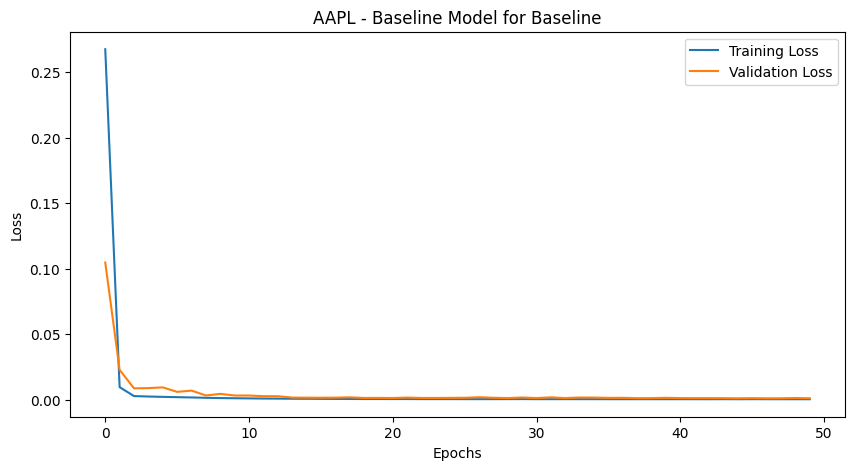

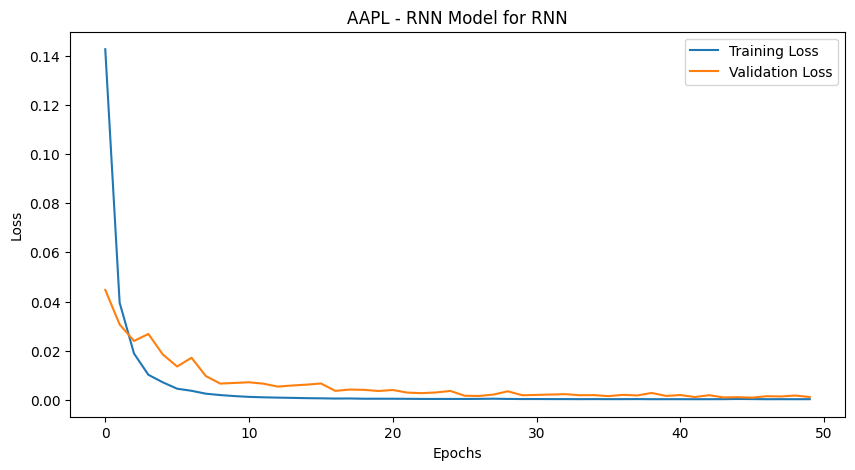

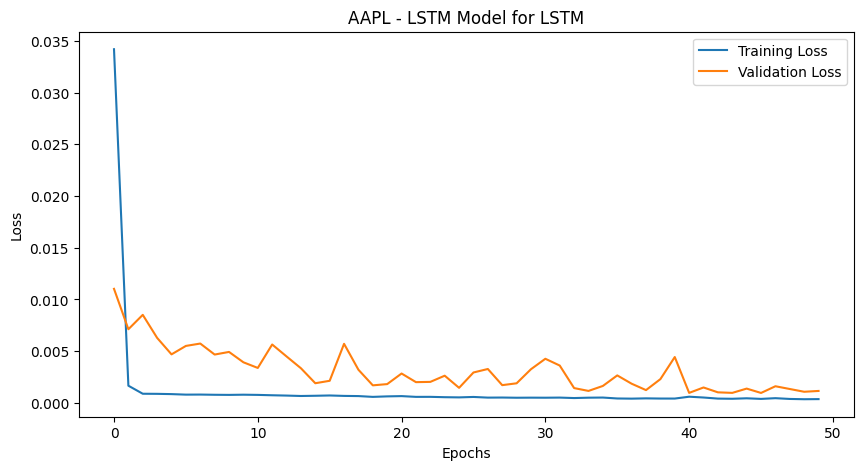

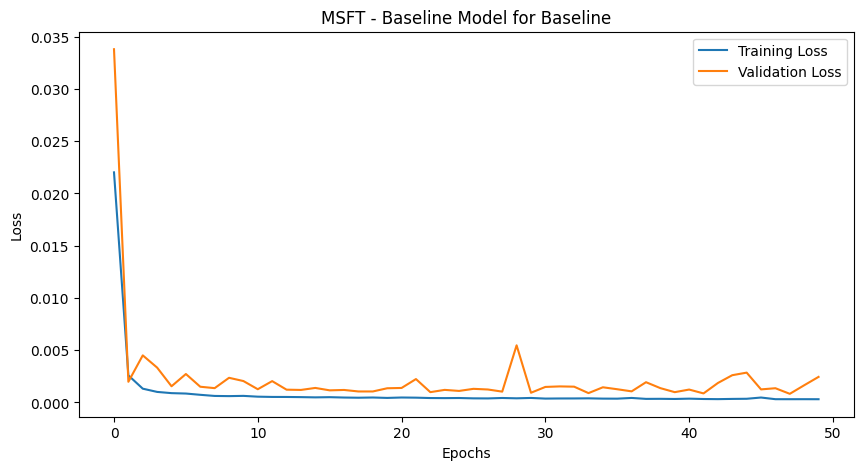

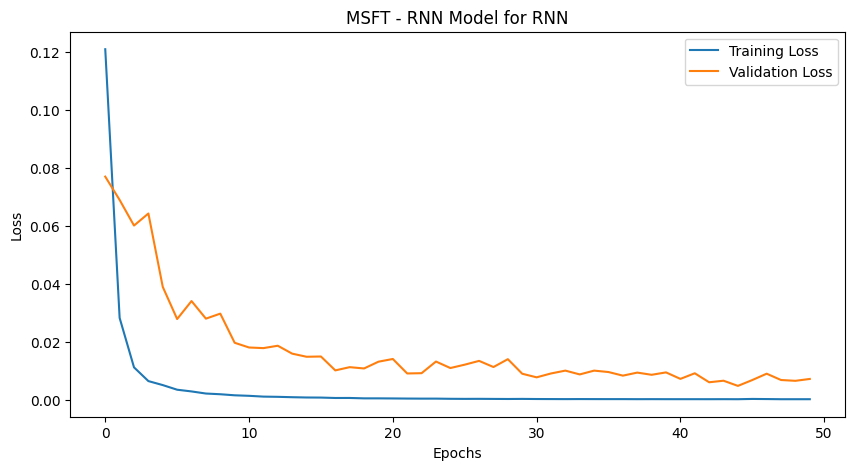

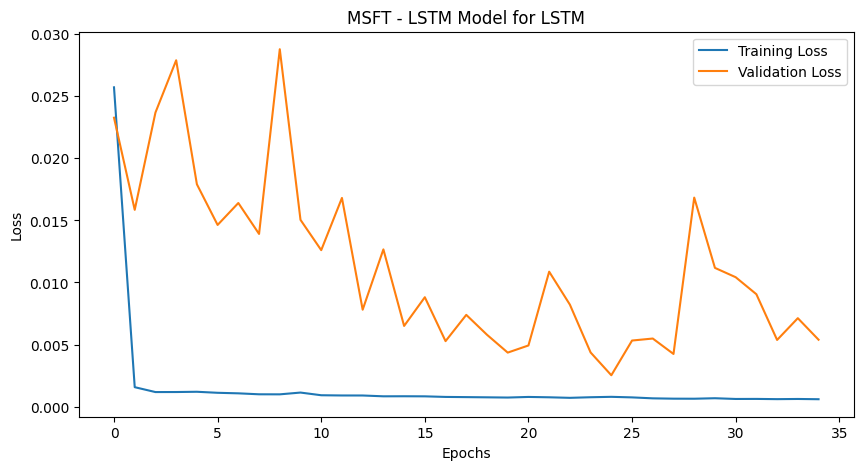

In [ ]:
for (stock, model), details in best_timestamps.items():
    _, _, history, _, _, _, _, _, _, _ = details
    plot_loss_curves(history, model, f'{stock} - {model} Model')

#### Plot Actual vs. Predicted Values with Future Predictions

1/1 [==============================] - 0s 18ms/step


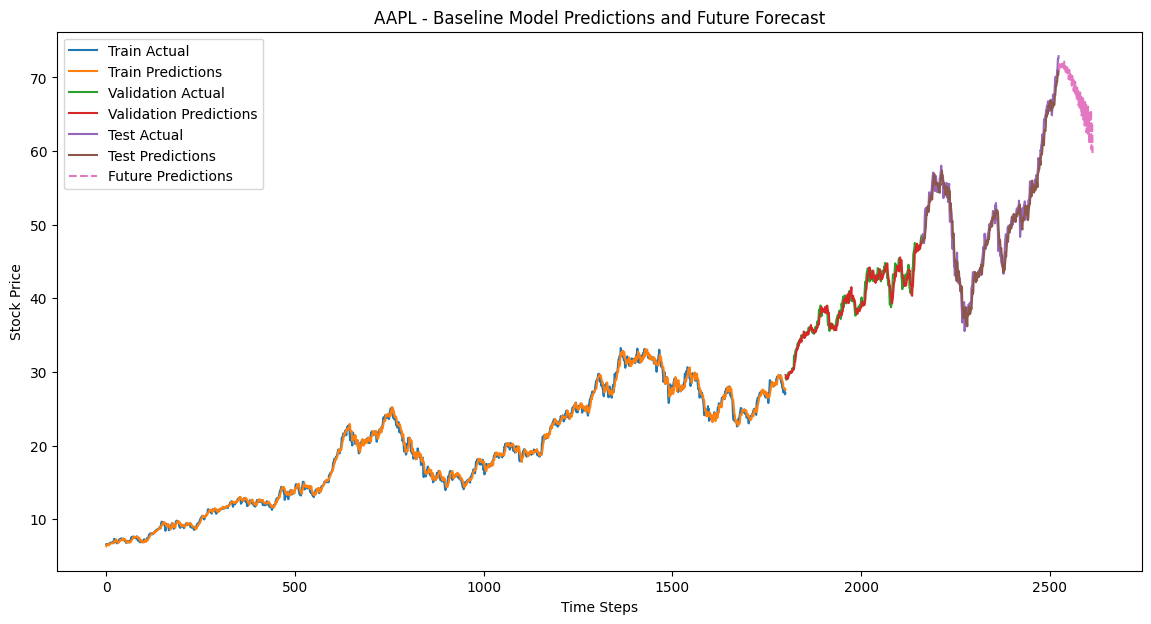

1/1 [==============================] - 0s 25ms/step


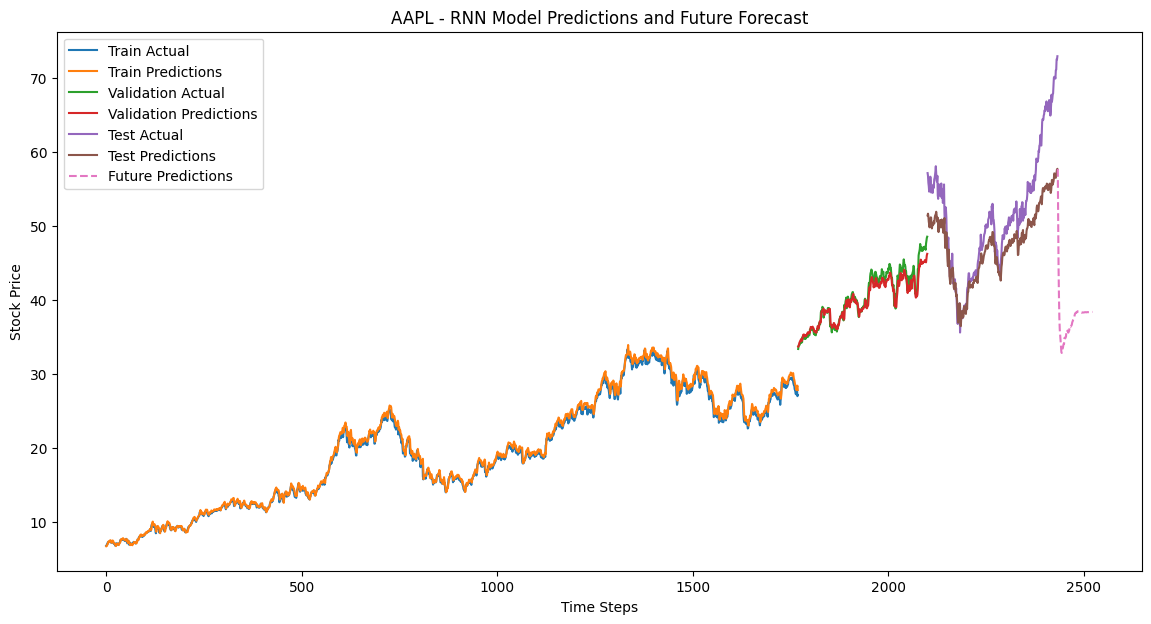

1/1 [==============================] - 0s 25ms/step


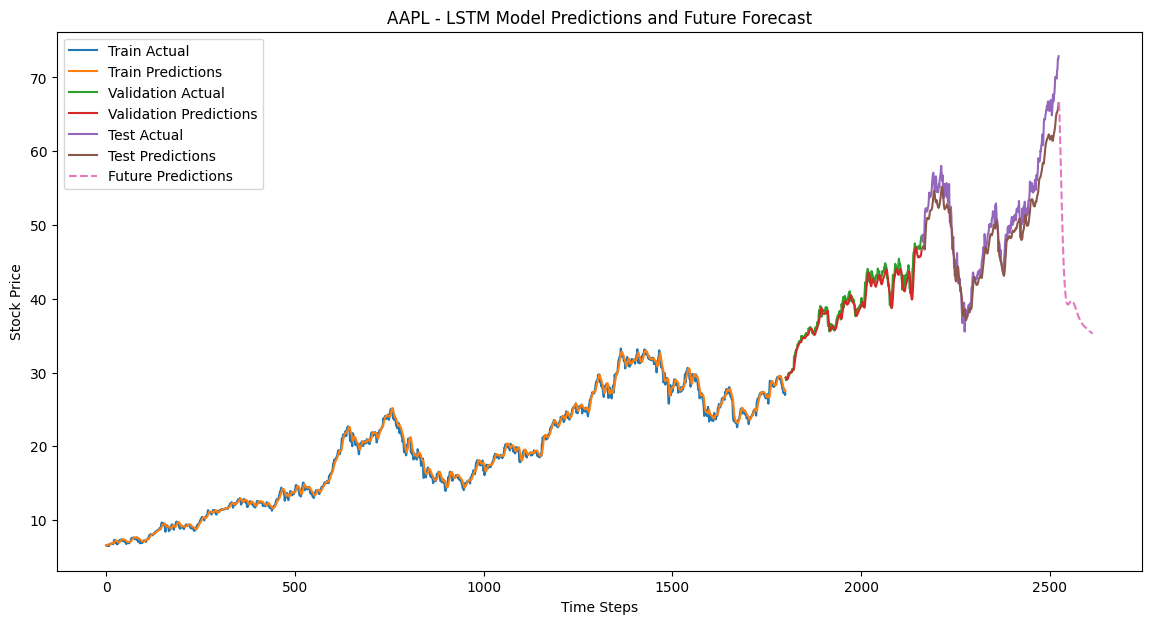

1/1 [==============================] - 0s 16ms/step


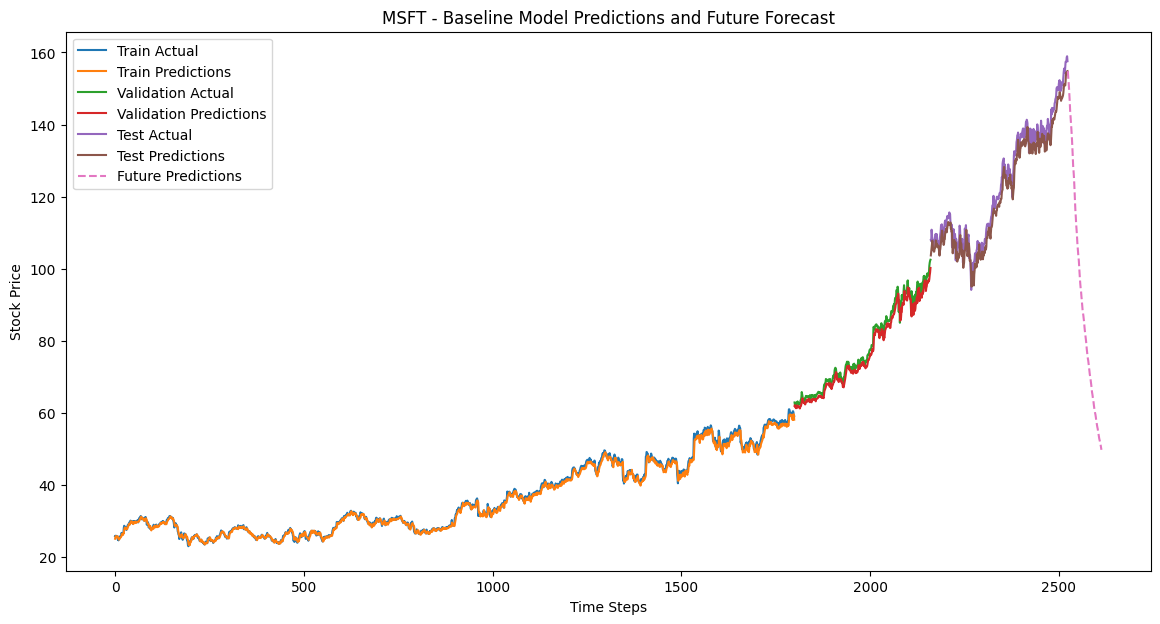

1/1 [==============================] - 0s 20ms/step


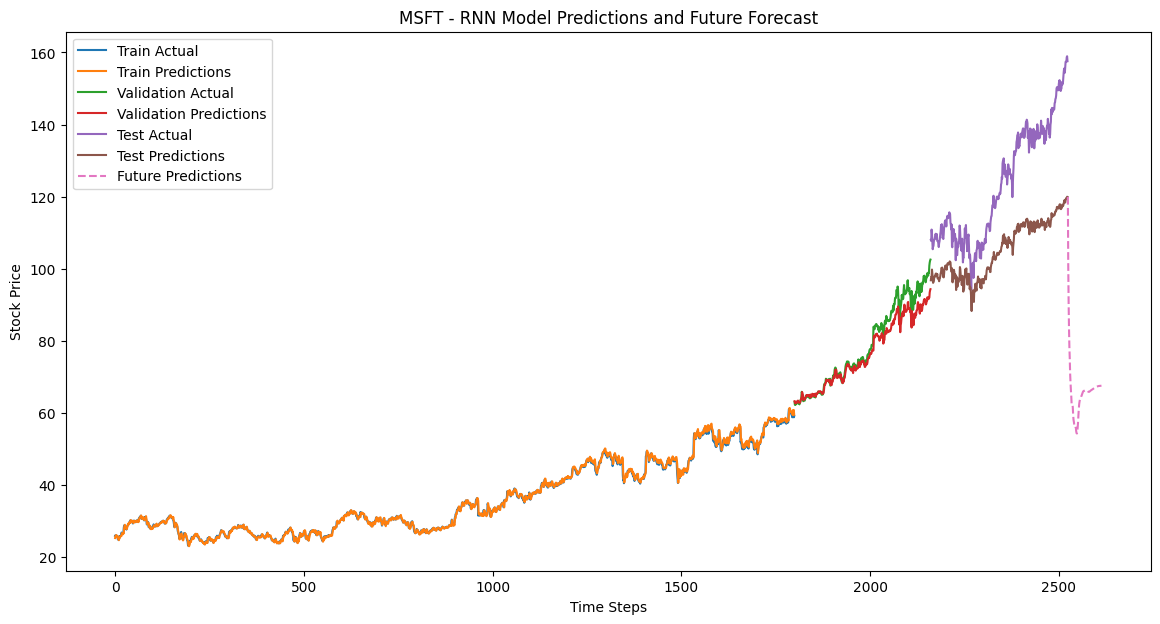

1/1 [==============================] - 0s 25ms/step


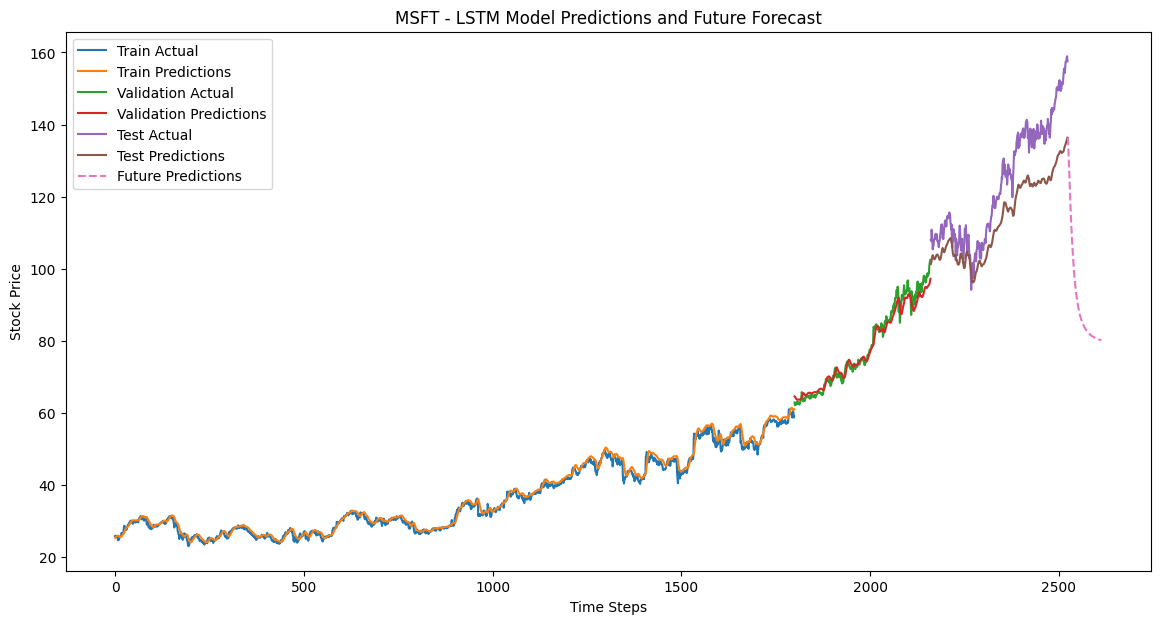

In [ ]:
for stock in ['AAPL', 'MSFT']:
    for model in ['Baseline', 'RNN', 'LSTM']:
        if (stock, model) in best_timestamps:
            plot_full_prediction(best_timestamps, stock, model, future_steps=90)